In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler 
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix 

import os
import sys
import random

from matplotlib import pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import SGD, Nadam, Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.models import Sequential, load_model

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras import optimizers

In [2]:
# hyperparameters

step = 60
batch_size = 32
optimizer = 'adam'
verbose = 1
data_dir = "Downloads/depression_data"
segment_length = 5760
learning_rate = 0.00001

In [3]:
step = 60 
batch_size = 16
optimizer = optimizers.Adam(lr = 0.00001) # learning rate is very low, otherwise the gradients exploded
verbose = 1
data_dir = "Downloads/depression_data"

In [4]:
MADRS_LABLES = ['Normal', 'Mild', 'Moderate']
MADRS_VALUES = [0, 7, 20]
classes = len(MADRS_VALUES)

In [5]:
def create_segments_and_labels_madrs_loo(dataset_dir, segment_length, step, leave_out_id=None):
    scores = pd.read_csv(os.path.join(dataset_dir, 'scores.csv'))
    scores['madrs2'].fillna(0, inplace=True)
    
    segments = []
    labels = []

    left_out_segments = []
    left_out_correct = None

    if leave_out_id == None:
        leave_out_id = random.randint(0, len(scores['number']))

    for i, person in enumerate(scores['number']):
        p = scores[scores['number'] == person]
        filepath = os.path.join(dataset_dir, person.split('_')[0], f'{person}.csv')
        df_activity = pd.read_csv(filepath)

        p_label = None

        for j in range(classes):
            if p['madrs2'].values[0] >= MADRS_VALUES[classes - j - 1]:
                p_label = classes - j - 1
                break

        assert p_label != None, f'Could not get target label: {p}'

        # For the participant that we are leaving out
        if i == leave_out_id:
            left_out_correct = p_label

        for j in range(0, len(df_activity) - segment_length, step):
            segment = df_activity['activity'].values[j : j + segment_length]
            
            # For the participant that we are leaving out
            if i == leave_out_id:
                left_out_segments.append([segment])
            else:
                segments.append([segment])
                labels.append(p_label)

    assert left_out_correct != None and len(left_out_segments) > 0, f'Did not set data for left out participant {leave_out_id}'
    
    labels = np.asarray(labels).astype('float32')
    labels = to_categorical(labels, 3)
    
    segments = np.asarray(segments).reshape(-1, segment_length, 1)
    left_out_segments = np.asarray(left_out_segments).reshape(-1, segment_length, 1)

    num_time_periods, num_sensors = segments.shape[1], segments.shape[2]
    input_shape = num_time_periods * num_sensors

    segments = segments.reshape(segments.shape[0], input_shape).astype('float32')
    left_out_segments = left_out_segments.reshape(left_out_segments.shape[0], input_shape).astype('float32')
    
    return segments, labels, input_shape

In [6]:
segments, labels, input_shape = create_segments_and_labels_madrs_loo(data_dir,segment_length,step)

In [7]:
# splitting dataset

X_train, X_test, y_train, y_test = train_test_split(segments, labels, test_size=0.2, random_state=777)
print(X_train.shape)
print()
print(X_test.shape)
print()
print(y_train.shape)
print()
print(y_test.shape)

(16444, 5760)

(4111, 5760)

(16444, 3)

(4111, 3)


In [8]:
# splitting dataset

X_train, X_test, y_train, y_test = train_test_split(segments, labels, test_size=0.2, random_state=777)
print(X_train.shape)
print()
print(X_test.shape)
print()
print(y_train.shape)
print()
print(y_test.shape)

(16444, 5760)

(4111, 5760)

(16444, 3)

(4111, 3)


In [9]:
sc = MinMaxScaler(feature_range = (0,1))
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.fit_transform(X_test)
y_train_scaled = sc.fit_transform(y_train)
y_test_scaled = sc.fit_transform(y_test)

print(X_train_scaled.shape)
print()
print(X_test_scaled.shape)
print()
print(y_train_scaled.shape)
print()
print(y_test_scaled.shape)

(16444, 5760)

(4111, 5760)

(16444, 3)

(4111, 3)


In [10]:
X_train_scaled_res = np.reshape(X_train_scaled, (X_train_scaled.shape[0], X_train_scaled.shape[1], 1))

y_train_scaled_res = np.reshape(y_train_scaled, (y_train_scaled.shape[0], y_train_scaled.shape[1], 1))

X_train_res = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

y_train_res = np.reshape(y_train, (y_train.shape[0], y_train.shape[1], 1))

X_test_scaled_res = np.reshape(X_test_scaled, (X_test_scaled.shape[0], X_test_scaled.shape[1], 1))

y_test_scaled_res = np.reshape(y_test_scaled, (y_test_scaled.shape[0], y_test_scaled.shape[1], 1))

X_test_res = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

y_test_res = np.reshape(y_test, (y_test.shape[0], y_test.shape[1], 1))

In [11]:
train_labels = np.argmax(y_train_scaled_res, axis=1)
test_labels = np.argmax(y_test_scaled_res, axis=1)

print(train_labels)

[[0]
 [1]
 [0]
 ...
 [0]
 [0]
 [0]]


In [12]:
def build_model():
    model = Sequential()
    model.add(LSTM(units = 30, return_sequences = True, input_shape = (X_train_scaled.shape[1], 1)))
    model.add(Dropout(0.2))
    model.add(LSTM(units = 30, return_sequences = True, activation = 'relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='relu'))
    model.compile(optimizer = optimizer, 
                  loss = "sparse_categorical_crossentropy", 
                  metrics = 'accuracy')
    
    return model

In [13]:
train_data = X_train_scaled_res
train_targets = train_labels
k = 3
num_val_samples = len(train_data) // k
num_epochs = 4
all_scores = [] # Should add the score of each run at the end of the loop
all_mae_histories = []
val_all_mae_histories = []

for i in range(k):
    print('processing fold #', i)
    # Prepare the validation data: data from partition # k
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

    # Prepare the training data: data from all other partitions
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)

    # Build the Keras model 
    model = build_model()
    # Train the model 
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=batch_size, verbose=1)
    mae_history = history.history['accuracy']
    all_mae_histories.append(mae_history)
    val_mae_history = history.history['val_accuracy']
    val_all_mae_histories.append(val_mae_history)
    
    # Evaluate the model on the validation data
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=1)
    all_scores.append(val_mae)

processing fold # 0
Epoch 1/4
686/686 [==============================] - 2853s 4s/step - loss: 9.7121 - accuracy: 0.6609 - val_loss: 6.8124 - val_accuracy: 0.6643
Epoch 2/4
686/686 [==============================] - 3088s 5s/step - loss: 4.8122 - accuracy: 0.6583 - val_loss: 1.1479 - val_accuracy: 0.6643
Epoch 3/4
686/686 [==============================] - 3118s 5s/step - loss: 1.7256 - accuracy: 0.6538 - val_loss: 1.3324 - val_accuracy: 0.6643
Epoch 4/4
172/172 [==============================] - 2315s 14s/step - loss: 1.1873 - accuracy: 0.6643
processing fold # 1
Epoch 1/4
686/686 [==============================] - 5878s 9s/step - loss: 4.7538 - accuracy: 0.6687 - val_loss: 1.5402 - val_accuracy: 0.6557
Epoch 2/4
686/686 [==============================] - 3059s 4s/step - loss: 1.7174 - accuracy: 0.6595 - val_loss: 1.3114 - val_accuracy: 0.6557
Epoch 3/4
686/686 [==============================] - 3090s 5s/step - loss: 1.4372 - accuracy: 0.6599 - val_loss: 1.2394 - val_accuracy: 0.6557


In [31]:
print(np.mean([0.6643,0.6557,0.6606]))

0.6602


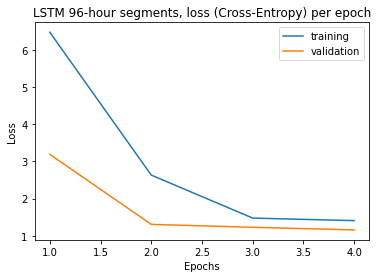

In [26]:
average_loss = [6.482499999999999,2.6336,1.4749999999999999,1.4064333333333334]
average_val_loss = [3.192966666666667,1.3048,1.2267666666666666,1.1562000000000001]

plt.plot(range(1, len(average_loss) + 1), average_loss)
plt.plot(range(1, len(average_val_loss) + 1), average_val_loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['training', 'validation'])
plt.title('LSTM 96-hour segments, loss (Cross-Entropy) per epoch')
plt.show()

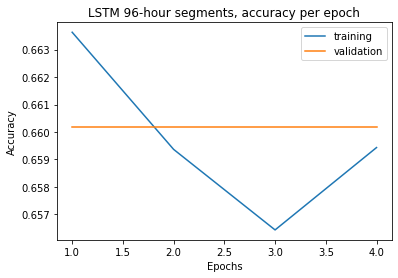

In [32]:
average_loss = [0.6636333333333334,0.6593666666666667,0.6564333333333333,0.6594333333333333]
average_val_loss = [0.6602,0.6602,0.6602,0.6602]

plt.plot(range(1, len(average_loss) + 1), average_loss)
plt.plot(range(1, len(average_val_loss) + 1), average_val_loss)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['training','validation'])
plt.title('LSTM 96-hour segments, accuracy per epoch')
plt.show()

In [14]:
print("Accuracy of fold 1, 2 and 3:\n")
print(all_scores)
print()
print("Mean Accuracy of all folds:\n")
print(np.mean(all_scores))

Accuracy of fold 1, 2 and 3:

[0.6642948389053345, 0.6557197570800781, 0.6606458425521851]

Mean Accuracy of all folds:

0.6602201461791992


In [16]:
test_data = X_test_scaled_res 
test_targets = test_labels
y_pred = model.evaluate(X_test_scaled_res,test_labels)

129/129 [==============================] - 74s 569ms/step - loss: 1.1121 - accuracy: 0.6570
